In [125]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
import tabulate


In [126]:
df = pd.read_csv("coronarias_drop (1).csv", sep=';')
df = df.dropna()
# O .copy() cria um novo DataFrame independente, resolvendo o aviso
var_analise = df[['COL','TRIG','PESO','IMC','PSR','PDR']].copy()

In [127]:
# Supondo que 'variaveis_para_analise' é o seu DataFrame com os dados

# --- PASSO 1: Checar Variância Zero ---
print("Checando variâncias (colunas com 0.0 são um problema):")
print(var_analise.var())

# Identificar colunas com variância zero
colunas_problematicas_var = var_analise.columns[var_analise.var() == 0]
if not colunas_problematicas_var.empty:
    print(f"\n[PROBLEMA] Remova estas colunas (variância zero): {list(colunas_problematicas_var)}")


# --- PASSO 2: Checar Multicolinearidade Perfeita ---
print("\n--- Matriz de Correlação ---")
corr_matrix = var_analise.corr().abs()
print(corr_matrix.to_markdown(floatfmt=".3f"))

# Cria uma máscara para esconder a diagonal (onde a correlação é sempre 1.0)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar colunas com correlação perfeita (1.0)
colunas_problematicas_corr = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.999)]
if colunas_problematicas_corr:
    print(f"\n[PROBLEMA] Encontrada correlação quase perfeita (>= 0.999) nestas colunas. Considere remover uma de cada par:")
    print(upper_tri[colunas_problematicas_corr].stack().loc[lambda x: x >= 0.999])
## 1.1. Teste KMO (Kaiser-Meyer-Olkin)

kmo_all, kmo_model = calculate_kmo(var_analise)

print(f"KMO Teste (Geral): {kmo_model:.3f}")

print("=== MSA Individual (por variável) ===")
msa_df = pd.DataFrame({
    'Variável': var_analise.columns,
    'MSA': kmo_all
}).sort_values(by='MSA', ascending=False)

print(msa_df)

Checando variâncias (colunas com 0.0 são um problema):
COL      2505.430694
TRIG    10261.813892
PESO      171.269403
IMC        15.803304
PSR         5.234883
PDR         1.337041
dtype: float64

--- Matriz de Correlação ---
|      |   COL |   TRIG |   PESO |   IMC |   PSR |   PDR |
|:-----|------:|-------:|-------:|------:|------:|------:|
| COL  | 1.000 |  0.335 |  0.048 | 0.088 | 0.045 | 0.046 |
| TRIG | 0.335 |  1.000 |  0.108 | 0.087 | 0.032 | 0.068 |
| PESO | 0.048 |  0.108 |  1.000 | 0.812 | 0.035 | 0.106 |
| IMC  | 0.088 |  0.087 |  0.812 | 1.000 | 0.116 | 0.146 |
| PSR  | 0.045 |  0.032 |  0.035 | 0.116 | 1.000 | 0.653 |
| PDR  | 0.046 |  0.068 |  0.106 | 0.146 | 0.653 | 1.000 |
KMO Teste (Geral): 0.509
=== MSA Individual (por variável) ===
  Variável       MSA
1     TRIG  0.532031
5      PDR  0.522460
3      IMC  0.511063
0      COL  0.509067
2     PESO  0.500322
4      PSR  0.499357


In [128]:
# --- PASSO 3: Teste de Esfericidade de Bartlett ---
# Verifica se a matriz de correlação é significativamente diferente de uma matriz identidade
# H0: A matriz de correlação é uma matriz identidade (variáveis não correlacionadas)
chi_square_value, p_value = calculate_bartlett_sphericity(var_analise)
print(f"\n=== Teste de Esfericidade de Bartlett ===")
print(f"Qui-quadrado: {chi_square_value:.3f}")
print(f"P-valor: {p_value:.4e}")

if p_value < 0.05:
    print("Resultado: Rejeita-se H0. A Análise Fatorial É ADEQUADA.")
else:
    print("Resultado: Aceita-se H0. CUIDADO: A Análise Fatorial pode NÃO ser adequada.")


=== Teste de Esfericidade de Bartlett ===
Qui-quadrado: 1766.583
P-valor: 0.0000e+00
Resultado: Rejeita-se H0. A Análise Fatorial É ADEQUADA.



--- Analisando Autovalores (Eigenvalues) ---
Autovalores: [2.005 1.52  1.28  0.667 0.346 0.182]
Sugestão de fatores (Critério de Kaiser > 1): 3


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


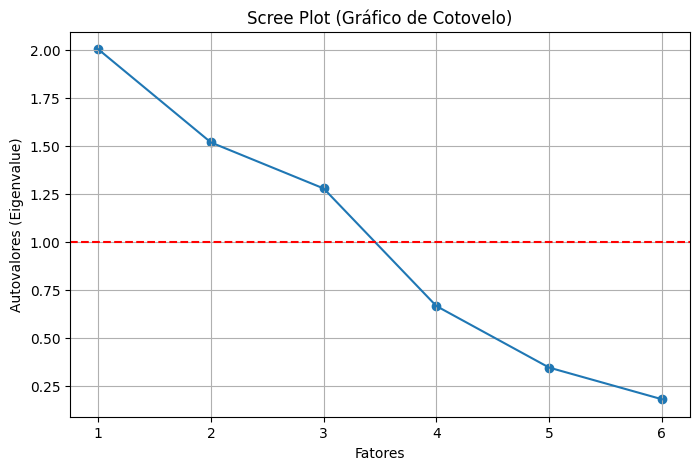

In [129]:
# --- PASSO 4: Determinação do Número de Fatores (Eigenvalues e Scree Plot) ---
print("\n--- Analisando Autovalores (Eigenvalues) ---")
# Instancia um objeto temporário para calcular autovalores sem rotação
fa_temp = FactorAnalyzer(rotation=None, impute='mean', n_factors=len(var_analise.columns))
fa_temp.fit(var_analise)
ev, v = fa_temp.get_eigenvalues()

# Critério de Kaiser: Autovalores > 1
n_fatores_kaiser = sum(ev > 1)
print(f"Autovalores: {np.round(ev, 3)}")
print(f"Sugestão de fatores (Critério de Kaiser > 1): {n_fatores_kaiser}")

# Gráfico de Cotovelo (Scree Plot)
plt.figure(figsize=(8, 5))
plt.scatter(range(1, var_analise.shape[1]+1), ev)
plt.plot(range(1, var_analise.shape[1]+1), ev)
plt.title('Scree Plot (Gráfico de Cotovelo)')
plt.xlabel('Fatores')
plt.ylabel('Autovalores (Eigenvalue)')
plt.axhline(y=1, color='r', linestyle='--') # Linha de corte Kaiser
plt.grid()
plt.show()

In [ ]:
# --- PASSO 5: Rodando a Análise Fatorial Final ---
# Aqui usamos o número de fatores sugerido pelo critério de Kaiser (ou defina manualmente, ex: n_factors=2)
fa_final = FactorAnalyzer(n_factors=n_fatores_kaiser, rotation=None)
fa_final.fit(var_analise)

ValueError: The rotation must be one of the following: ['varimax', 'oblimax', 'quartimax', 'equamax', 'geomin_ort', 'promax', 'oblimin', 'quartimin', 'geomin_obl', None]


=== Cargas Fatoriais (Factor Loadings) ===
      Fator_1  Fator_2  Fator_3
COL     0.028    0.028    0.571
TRIG    0.062    0.028    0.582
PESO    0.934    0.022    0.062
IMC     0.856    0.101    0.079
PSR     0.024    0.844    0.023
PDR     0.084    0.767    0.055


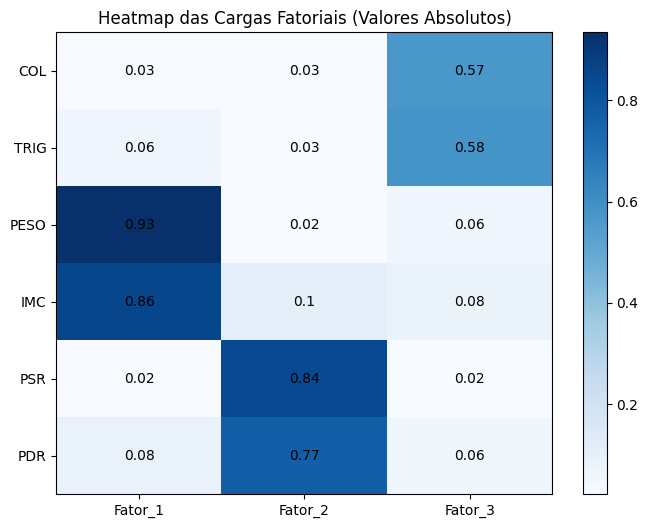

In [ ]:
# --- PASSO 6: Interpretando as Cargas Fatoriais (Loadings) ---
print("\n=== Cargas Fatoriais (Factor Loadings) ===")
# Criando um DataFrame para facilitar a visualização
colunas_fatores = [f'Fator_{i+1}' for i in range(n_fatores_kaiser)]
loadings_df = pd.DataFrame(fa_final.loadings_, 
                           index=var_analise.columns, 
                           columns=colunas_fatores)

# Destaque para cargas altas (> 0.4 ou < -0.4 é uma regra de bolso comum)
print(loadings_df.round(3))

# Visualização gráfica das cargas (Heatmap simplificado com matplotlib)
plt.figure(figsize=(8, 6))
plt.imshow(loadings_df.abs(), cmap="Blues", aspect='auto')
plt.colorbar()
plt.yticks(range(len(loadings_df)), loadings_df.index)
plt.xticks(range(len(loadings_df.columns)), loadings_df.columns)
plt.title('Heatmap das Cargas Fatoriais (Valores Absolutos)')
for i in range(len(loadings_df.index)):
    for j in range(len(loadings_df.columns)):
        text = plt.text(j, i, round(loadings_df.iloc[i, j], 2),
                       ha="center", va="center", color="black")
plt.show()


In [ ]:
# --- PASSO 7: Comunalidades e Variância Explicada ---
print("\n=== Comunalidades ===")
# Quanto da variância da variável é explicada pelos fatores extraídos
communalities = pd.DataFrame(fa_final.get_communalities(), 
                             index=var_analise.columns, 
                             columns=['Comunalidade'])
print(communalities.sort_values(by='Comunalidade', ascending=False).round(3))

print("\n=== Variância Explicada ===")
variance_df = pd.DataFrame(fa_final.get_factor_variance(), 
                           index=['SS Loadings (Variância)', 'Proporção Var.', 'Proporção Acumulada'],
                           columns=colunas_fatores)
print(variance_df.round(3))


=== Comunalidades ===
      Comunalidade
PESO         0.877
IMC          0.748
PSR          0.714
PDR          0.599
TRIG         0.344
COL          0.327

=== Variância Explicada ===
                         Fator_1  Fator_2  Fator_3
SS Loadings (Variância)    1.617    1.314    0.678
Proporção Var.             0.270    0.219    0.113
Proporção Acumulada        0.270    0.489    0.602


In [ ]:
# --- PASSO 8: Adicionando os Fatores ao DataFrame Original ---
# Transforma os dados originais nos escores dos fatores
fator_scores = fa_final.transform(var_analise)

# Adiciona ao DataFrame original (cuidado com índices se houve dropna antes)
# Como fizemos dropna no inicio e criamos 'var_analise', o alinhamento é direto
for i, col_name in enumerate(colunas_fatores):
    var_analise[col_name] = fator_scores[:, i]

print("\n=== Primeiras linhas com os Novos Fatores ===")
print(var_analise.head().round(3))


=== Primeiras linhas com os Novos Fatores ===
     COL   TRIG  PESO    IMC   PSR  PDR  Fator_1  Fator_2  Fator_3
0  202.0  171.0  88.0  37.11  16.0  9.0    1.539    0.682   -0.125
1  225.0  167.0  73.0  27.48  11.0  8.0    0.074   -0.952    0.056
2  258.0   92.0  67.0  26.17  14.0  9.0   -0.379    0.175   -0.003
3  184.0  110.0  87.0  26.85  13.0  8.0    0.790   -0.487   -0.598
4  241.0  304.0  62.0  23.34  14.0  9.0   -0.916    0.165    0.768


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\factor_analyzer\utils.py:166: RuntimeWarning: divide by zero encountered in divide
  smc = 1 - 1 / np.diag(corr_inv)


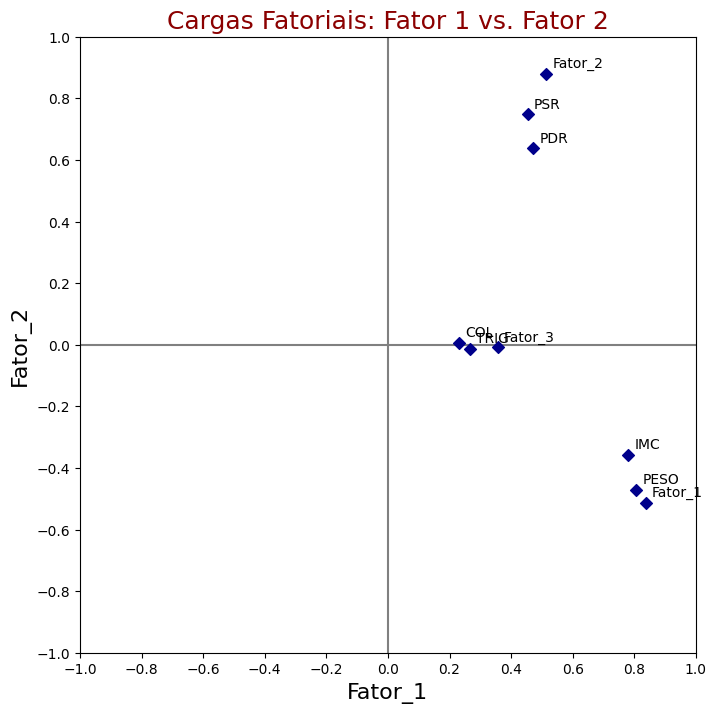

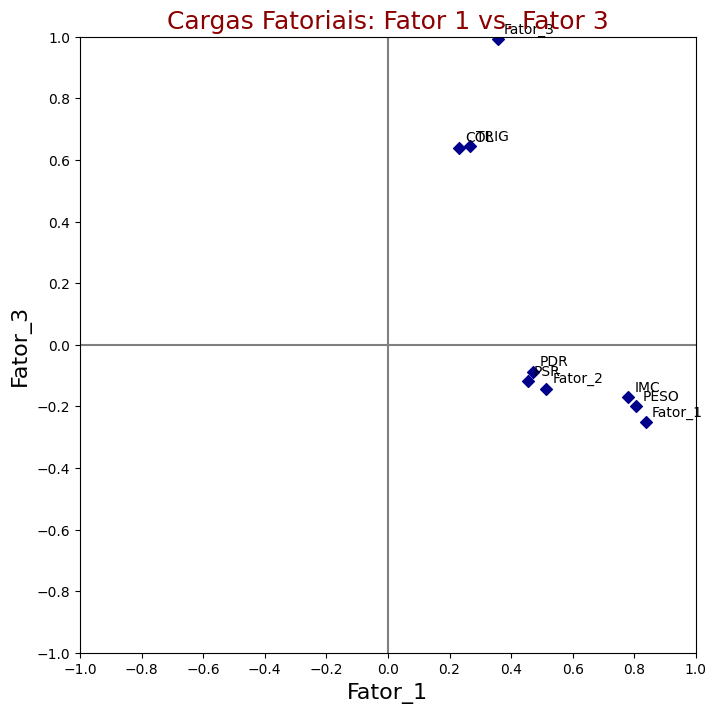

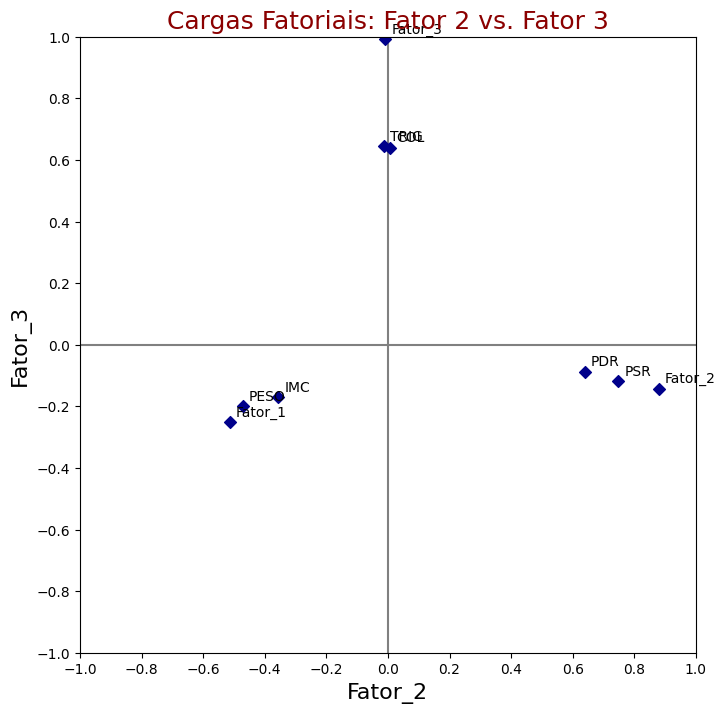

In [ ]:
# Importar a biblioteca 'FactorAnalyzer' se ainda não estiver
# from factor_analyzer import FactorAnalyzer 
# Importar pandas se necessário
# import pandas as pd 

# 1. Instanciar o modelo SEM rotação e com o número correto de fatores (n_fatores_kaiser)
# Usando None ou '' é o método correto para indicar "sem rotação"
fa_norotation = FactorAnalyzer(n_factors=n_fatores_kaiser, rotation=None) 

# 2. AJUSTAR O MODELO AOS DADOS (PASSO CRUCIAL FALTANTE)
fa_norotation.fit(var_analise) 

# 3. Acessar o atributo .loadings_ para obter o DataFrame
loadingsnovo_df = pd.DataFrame(
    fa_norotation.loadings_, 
    index=var_analise.columns, 
    columns=colunas_fatores # Assumindo que 'colunas_fatores' está definida
)

# Pronto, loadingsnovo_df agora contém as cargas não rotacionadas.
def plot_cargas_fatoriais_3d(cargas_df, fator1_nome, fator2_nome, titulo):
    """Gera o gráfico de cargas fatoriais 2D para um par de fatores."""
    
    plt.figure(figsize=(8, 8))
    
    # 2. Scatter Plot dos pontos
    plt.scatter(
        cargas_df[fator1_nome], 
        cargas_df[fator2_nome], 
        marker='D', 
        color='darkblue'
    )
    
    # Adicionar rótulos das variáveis
    for i in range(len(cargas_df)):
        plt.text(cargas_df.iloc[i][fator1_nome] + 0.02, 
                 cargas_df.iloc[i][fator2_nome] + 0.02, 
                 cargas_df.index[i], fontsize=10)
    
    # 3. Desenho das linhas de referência (eixos)
    plt.axhline(0, color='gray', linestyle='-', zorder=0)
    plt.axvline(0, color='gray', linestyle='-', zorder=0)
    
    # 4. Configuração dos limites e labels
    limite = 1.0 
    plt.xlim(-limite, limite)
    plt.ylim(-limite, limite)
    
    # Rótulos dos Eixos Dinâmicos
    plt.xlabel(f'{fator1_nome}', fontsize=16)
    plt.ylabel(f'{fator2_nome}', fontsize=16)
    
    # Configurar Ticks
    ticks = [round(i * 0.2, 2) for i in range(-5, 6)]
    plt.xticks(ticks)
    plt.yticks(ticks)
    
    # 5. Título
    plt.title(titulo, color='darkred', fontsize=18)
    
    plt.grid(False) 
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    

# --- 3. Chamadas para os Três Pares de Fatores ---

# Par 1: Fator 1 vs. Fator 2
plot_cargas_fatoriais_3d(
    loadingsnovo_df, 
    'Fator_1', 
    'Fator_2', 
    'Cargas Fatoriais: Fator 1 vs. Fator 2',
)

# Par 2: Fator 1 vs. Fator 3
plot_cargas_fatoriais_3d(
    loadingsnovo_df, 
    'Fator_1', 
    'Fator_3', 
    'Cargas Fatoriais: Fator 1 vs. Fator 3',
)

# Par 3: Fator 2 vs. Fator 3
plot_cargas_fatoriais_3d(
    loadingsnovo_df, 
    'Fator_2', 
    'Fator_3', 
    'Cargas Fatoriais: Fator 2 vs. Fator 3',)

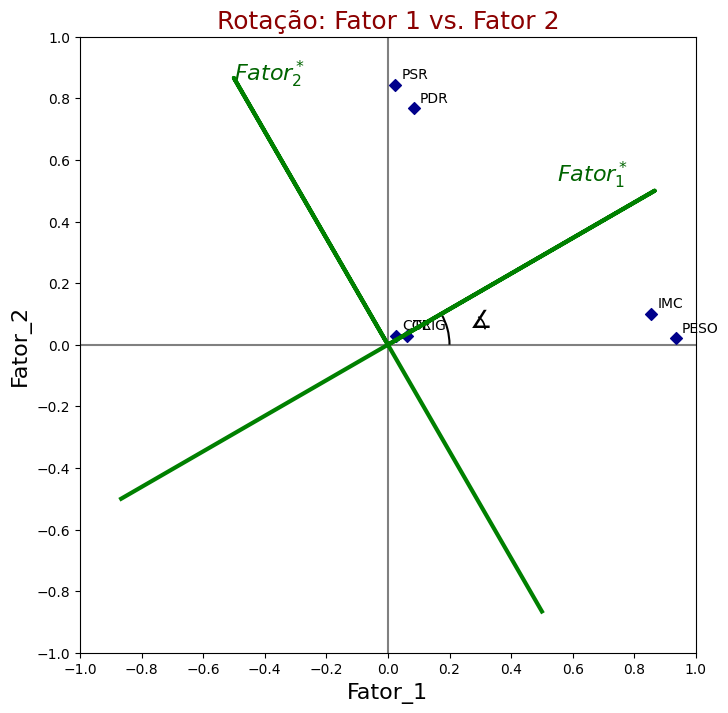

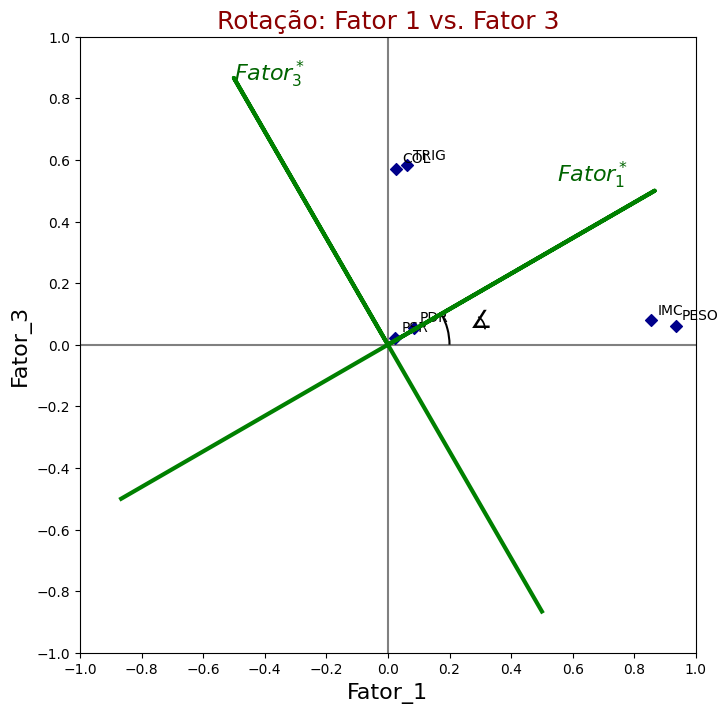

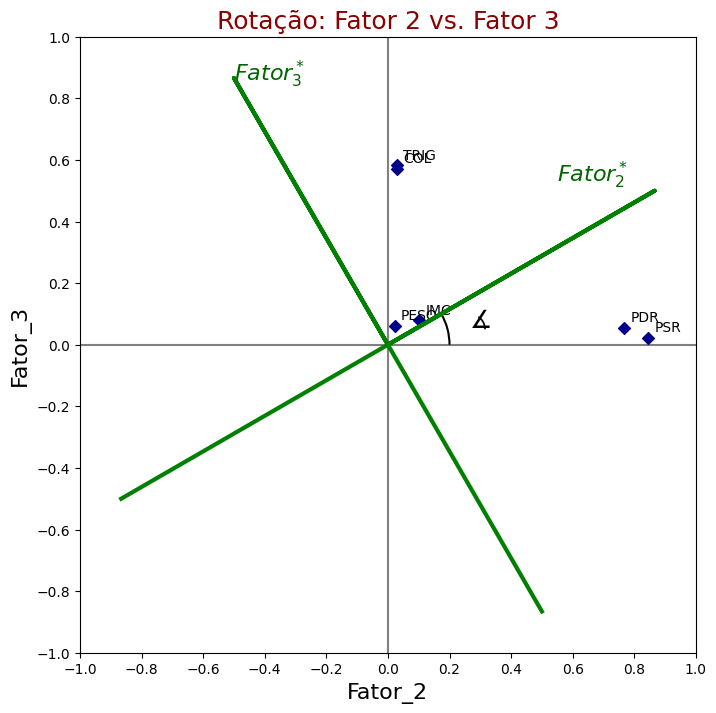

In [ ]:
from matplotlib.patches import Arc # <--- CORREÇÃO: Importar Arc aqui!
import math


def plot_rotacao_fatorial(cargas_df, fator1_nome, fator2_nome, angulo_graus, titulo):
    """Gera o gráfico de cargas fatoriais com eixos de rotação (visual) para um par de fatores."""
    
    # Use apenas as colunas necessárias para o plot 2D
    plot_df = cargas_df[[fator1_nome, fator2_nome]]
    
    # 1. Configuração do plot
    plt.figure(figsize=(8, 8))
    
    # Scatter Plot dos pontos
    plt.scatter(
        plot_df[fator1_nome], 
        plot_df[fator2_nome], 
        marker='D', 
        color='darkblue'
    )
    
    # Adicionar rótulos das variáveis
    for i in range(len(plot_df)):
        plt.text(plot_df.iloc[i][fator1_nome] + 0.02, 
                 plot_df.iloc[i][fator2_nome] + 0.02, 
                 plot_df.index[i], fontsize=10)
    
    # Desenho das linhas de referência (eixos não rotacionados)
    plt.axhline(0, color='gray', linestyle='-', zorder=0)
    plt.axvline(0, color='gray', linestyle='-', zorder=0)
    
    # 2. Configuração dos limites e labels
    limite = 1.0 
    plt.xlim(-limite, limite)
    plt.ylim(-limite, limite)
    plt.xlabel(f'{fator1_nome}', fontsize=16) 
    plt.ylabel(f'{fator2_nome}', fontsize=16)
    
    # Configurar Ticks
    ticks = [round(i * 0.2, 2) for i in range(-5, 6)]
    plt.xticks(ticks)
    plt.yticks(ticks)
    
    # 3. Desenho dos Eixos Rotacionados (Estilo Oblíquo para Reproduzir o Visual Original)
    
    angulo_rad = np.radians(angulo_graus)
    
    # Eixo Rotacionado 1 (Fator X*)
    x1_star = [0, limite * np.cos(angulo_rad), 0, -limite * np.cos(angulo_rad)]
    y1_star = [0, limite * np.sin(angulo_rad), 0, -limite * np.sin(angulo_rad)]
    
    # Eixo Rotacionado 2 (Fator Y*) - Ângulo = 90 + theta
    angulo_rad_2 = np.radians(angulo_graus + 90)
    x2_star = [0, limite * np.cos(angulo_rad_2), 0, -limite * np.cos(angulo_rad_2)]
    y2_star = [0, limite * np.sin(angulo_rad_2), 0, -limite * np.sin(angulo_rad_2)]
    
    # Desenha as linhas rotacionadas (em verde, grossa)
    plt.plot(x1_star, y1_star, color='green', linewidth=3, zorder=10)
    plt.plot(x2_star, y2_star, color='green', linewidth=3, zorder=10)
    
    # 4. Adicionar os rótulos dos novos eixos (X* e Y*)
    # Rótulo Eixo 1*
    plt.text(x1_star[1] * 0.9, y1_star[1] * 0.9 + 0.05, f'${fator1_nome}^*$', color='darkgreen', fontsize=16, ha='right', va='bottom')
    # Rótulo Eixo 2*
    plt.text(x2_star[1] * 0.9 - 0.05, y2_star[1] * 0.9 + 0.05, f'${fator2_nome}^*$', color='darkgreen', fontsize=16, ha='left', va='bottom')
    
    # 5. Desenhar o arco do ângulo
    arc = Arc((0, 0), 0.4, 0.4, angle=0, theta1=0, theta2=angulo_graus, color='black', linewidth=1.5)
    plt.gca().add_patch(arc)
    plt.text(0.3, 0.08, '$\\measuredangle$', fontsize=18, ha='center', va='center')

    # 6. Título e Rótulo
    plt.title(titulo, color='darkred', fontsize=18)
    plt.text(limite*0.8, -limite*0.9, '', fontsize=10, ha='right')
    
    plt.grid(False)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    plt.close()

# --- 3. Chamadas para os Três Pares de Fatores ---
# Usamos 30 graus para reproduzir o estilo visual da sua imagem, embora Varimax seja ortogonal.
ANGULO_ROTACAO_VISUAL = 30 

# Par 1: Fator 1 vs. Fator 2
plot_rotacao_fatorial(
    loadings_df, 
    'Fator_1', 
    'Fator_2', 
    angulo_graus=ANGULO_ROTACAO_VISUAL, 
    titulo='Rotação: Fator 1 vs. Fator 2'
)

# Par 2: Fator 1 vs. Fator 3
plot_rotacao_fatorial(
    loadings_df, 
    'Fator_1', 
    'Fator_3', 
    angulo_graus=ANGULO_ROTACAO_VISUAL, 
    titulo='Rotação: Fator 1 vs. Fator 3'
)

# Par 3: Fator 2 vs. Fator 3
plot_rotacao_fatorial(
    loadings_df, 
    'Fator_2', 
    'Fator_3', 
    angulo_graus=ANGULO_ROTACAO_VISUAL, 
    titulo='Rotação: Fator 2 vs. Fator 3'
)